Our plan is to use the tournament seeds as a predictor of tournament performance. 
We will train a logistic regressor on the difference in seeding between the two teams playing, and have the result of the game as the desired output

This is inspired by [last years competition][1], where [Jared Cross made a model just based on the team seeds][2].


  [1]: https://www.kaggle.com/c/march-machine-learning-mania-2016
  [2]: https://www.kaggle.com/jaredcross/march-machine-learning-mania-2016/getting-started

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSampleSubmissionStage1.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv



## Load the training data ##
We are just having a look at the format of the training data to make sure that it looks like we expect

In [4]:
data_dir = '../input/'
df_seeds = pd.read_csv(data_dir + 'MNCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'MNCAATourneyCompactResults.csv')

In [5]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [6]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


Let's drop the columns we are not planning on using

In [9]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)

Get the seeds as integers

In [10]:
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

## Merge seed for each team ##
We want the seeds in the same DataFrame as the game results

In [13]:
df_seeds

,Season,TeamID,n_seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5
...,...,...,...
2281,2019,1332,12
2282,2019,1414,13
2283,2019,1330,14
2284,2019,1159,15


In [14]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'n_seed':'loss_seed'})

In [16]:
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed

## Make a new DF with just the wins and losses ##

In [17]:
df_wins = pd.DataFrame()
df_wins['seed_diff'] = df_concat['seed_diff']
df_wins['result'] = 1

df_losses = pd.DataFrame()
df_losses['seed_diff'] = -df_concat['seed_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))

In [18]:
X_train = df_for_predictions.seed_diff.values.reshape(-1,1)
y_train = df_for_predictions.result.values
X_train, y_train = shuffle(X_train, y_train)

## Train the estimator ##
We use logistic regression, so we have to set a `C` value. We can just try a bunch of different values and then choose the best one.

In [19]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5537, with best C: 0.1


## Examine the classifier predictions ##

In [20]:
X = np.arange(-16, 16).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

Text(0, 0.5, 'P(Team1 will win)')

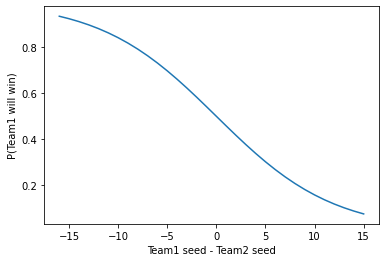

In [21]:
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

This looks like we would expect. We are predicting the probability of team1 winning. If that team has a lower seed than team2, there is a high probability of team1 winning.

## Get the test data ##

In [22]:
df_sample_sub = pd.read_csv(data_dir + 'MSampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

In [23]:
def get_year_t1_t2(id):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in id.split('_'))

We loop over each row in the `sample_submission.csv` file. For each row, we extract the year and the teams playing. 
We then look up the seeds for each of those teams *in that season*. 
Finally we add the seed difference to an array.

In [26]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    # There absolutely must be a better way of doing this!
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].n_seed.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].n_seed.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

## Make the predictions ##

In [27]:
preds = clf.predict_proba(X_test)[:,1]

In [28]:
clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.pred = clipped_preds
df_sample_sub.head()

<ipython-input-28-11e02b4eb2e5>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_sample_sub.pred = clipped_preds


,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5


In [30]:
df_sample_sub.to_csv('logreg_on_seed.csv', index=False)

In [29]:
df_sample_sub

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5
...,...,...
11385,2019_1449_1459,0.5
11386,2019_1449_1463,0.5
11387,2019_1458_1459,0.5
11388,2019_1458_1463,0.5
